# Multi-Factor Alpha Research - Interactive Mode

This notebook interactively calls the `run_backtest.py` script functions to perform alpha factor research.

---

## Setup: Import the QuantLab Library

In [17]:
# Add src to path and import required modules
import sys
from pathlib import Path

# Add the src directory to Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Import quantlab modules
from quantlab.config import settings, setup_logging
from quantlab.data import get_universe, load_prices, load_returns, clean_prices
from quantlab.alpha import (
    momentum, rsi, volatility, mean_reversion, composite_factor,
    calculate_ic, ic_analysis, calculate_forward_returns,
    run_long_short, calculate_metrics
)

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("QuantLab library loaded successfully!")
print(f"Project root: {project_root}")

QuantLab library loaded successfully!
Project root: /Users/msoumad/Desktop/quant-lab 2/quant_lab


---

## Step 1: Configure Backtest Parameters

Set your parameters interactively below:

In [18]:
# ============================================================
# INTERACTIVE CONFIGURATION
# Modify these parameters as needed
# ============================================================

# Universe Selection: 'dow30' or 'sp500'
UNIVERSE = 'dow30'

# Date Range
START_DATE = '2018-01-01'
END_DATE = '2024-12-01'

# Portfolio Parameters
TOP_PCT = 0.2        # Top 20% for long positions
BOTTOM_PCT = 0.2     # Bottom 20% for short positions
REBALANCE_FREQ = 'M' # 'D' = Daily, 'W' = Weekly, 'M' = Monthly

print(f"Configuration:")
print(f"  Universe: {UNIVERSE}")
print(f"  Period: {START_DATE} to {END_DATE}")
print(f"  Long/Short: Top/Bottom {TOP_PCT*100:.0f}%")
print(f"  Rebalance: {REBALANCE_FREQ}")

Configuration:
  Universe: dow30
  Period: 2018-01-01 to 2024-12-01
  Long/Short: Top/Bottom 20%
  Rebalance: M


---

## Step 2: Load Market Data

Using quantlab's data loaders to fetch price data:

In [19]:
# Get stock universe
tickers = get_universe(UNIVERSE)
print(f"Universe: {UNIVERSE} ({len(tickers)} stocks)")
print(f"Tickers: {', '.join(tickers[:10])}...")

# Load price data
print(f"\nLoading data from {START_DATE} to {END_DATE}...")
prices = load_prices(tickers, START_DATE, END_DATE)
prices = clean_prices(prices)

# Calculate returns
returns = prices.pct_change().dropna()

print(f"\nData loaded:")
print(f"  Trading days: {len(prices)}")
print(f"  Stocks: {len(prices.columns)}")
print(f"  Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")

Universe: dow30 (30 stocks)
Tickers: AAPL, AMGN, AXP, BA, CAT, CRM, CSCO, CVX, DIS, DOW...

Loading data from 2018-01-01 to 2024-12-01...


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}
$WBA: possibly delisted; no timezone found

1 Failed download:
['WBA']: possibly delisted; no timezone found
Removing 1 columns with >20% missing: {'WBA'}



Data loaded:
  Trading days: 1740
  Stocks: 29
  Date range: 2018-01-02 to 2024-11-29


In [20]:
# Preview the data
print("Price Data Preview:")
display(prices.tail())

print("\nReturns Data Preview:")
display(returns.tail())

Price Data Preview:


Ticker,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-22,228.621109,285.245209,297.428131,149.289993,390.662750,339.414368,56.774269,155.166962,113.880394,41.634796,...,126.040367,94.827431,413.946411,75.239494,170.531754,257.181854,574.465210,307.101013,39.682056,89.384476
2024-11-25,231.604813,284.731903,301.287872,153.100006,398.682556,336.526550,56.958511,153.255554,114.225029,42.010296,...,127.905159,96.720551,415.723297,77.047569,171.605560,255.957016,589.009888,310.341248,40.445347,88.455452
2024-11-26,233.782928,271.182922,301.643280,150.759995,400.825104,340.565521,57.782726,155.329422,113.683441,40.792210,...,130.486420,97.160355,424.855927,75.443626,173.462952,258.455627,589.943176,308.983734,40.804001,90.244316
2024-11-27,233.653625,271.240997,300.340240,152.399994,396.766083,327.495911,57.491829,154.928024,115.800552,40.883801,...,130.025116,98.594528,419.892517,76.153236,173.511322,261.287445,591.489075,311.837585,40.813202,90.807671
2024-11-29,236.040604,273.952759,300.764709,155.440002,399.134644,327.476013,57.414257,154.755997,115.672539,41.135017,...,131.055664,97.179466,420.359100,76.571236,173.414597,260.679932,593.258545,312.214081,40.776413,91.420441



Returns Data Preview:


Ticker,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-22,0.005908,0.015971,0.028328,0.041001,0.020278,0.018584,0.017199,0.004517,0.008107,0.014506,...,0.008640,-0.006809,0.010003,0.030626,0.020434,0.006365,-0.011080,0.000065,0.015294,0.023193
2024-11-25,0.013051,-0.001800,0.012977,0.025521,0.020529,-0.008508,0.003245,-0.012318,0.003026,0.009019,...,0.014795,0.019964,0.004293,0.024031,0.006297,-0.004763,0.025319,0.010551,0.019235,-0.010394
2024-11-26,0.009404,-0.047585,0.001180,-0.015284,0.005374,0.012002,0.014470,0.013532,-0.004741,-0.028995,...,0.020181,0.004547,0.021968,-0.020818,0.010824,0.009762,0.001585,-0.004374,0.008868,0.020223
2024-11-27,-0.000553,0.000214,-0.004320,0.010878,-0.010127,-0.038376,-0.005034,-0.002584,0.018623,0.002245,...,-0.003535,0.014761,-0.011683,0.009406,0.000279,0.010957,0.002620,0.009236,0.000225,0.006243
2024-11-29,0.010216,0.009998,0.001413,0.019948,0.005970,-0.000061,-0.001349,-0.001110,-0.001105,0.006145,...,0.007926,-0.014352,0.001111,0.005489,-0.000557,-0.002325,0.002992,0.001207,-0.000901,0.006748


---

## Step 3: Calculate Alpha Factors

Using quantlab's factor calculation functions:

In [21]:
# Calculate all factors using quantlab functions
print("Calculating factors...")

factors = {
    'Momentum': momentum(prices, lookback=252),
    'RSI': -rsi(prices, window=14),  # Inverted for contrarian
    'Low_Vol': -volatility(returns, window=60),
    'Mean_Rev': mean_reversion(prices, window=20)
}

print("Factors calculated:")
for name, factor in factors.items():
    non_null = factor.iloc[-1].notna().sum()
    print(f"  {name}: {non_null} stocks with valid values")

Calculating factors...
Factors calculated:
  Momentum: 29 stocks with valid values
  RSI: 29 stocks with valid values
  Low_Vol: 29 stocks with valid values
  Mean_Rev: 29 stocks with valid values


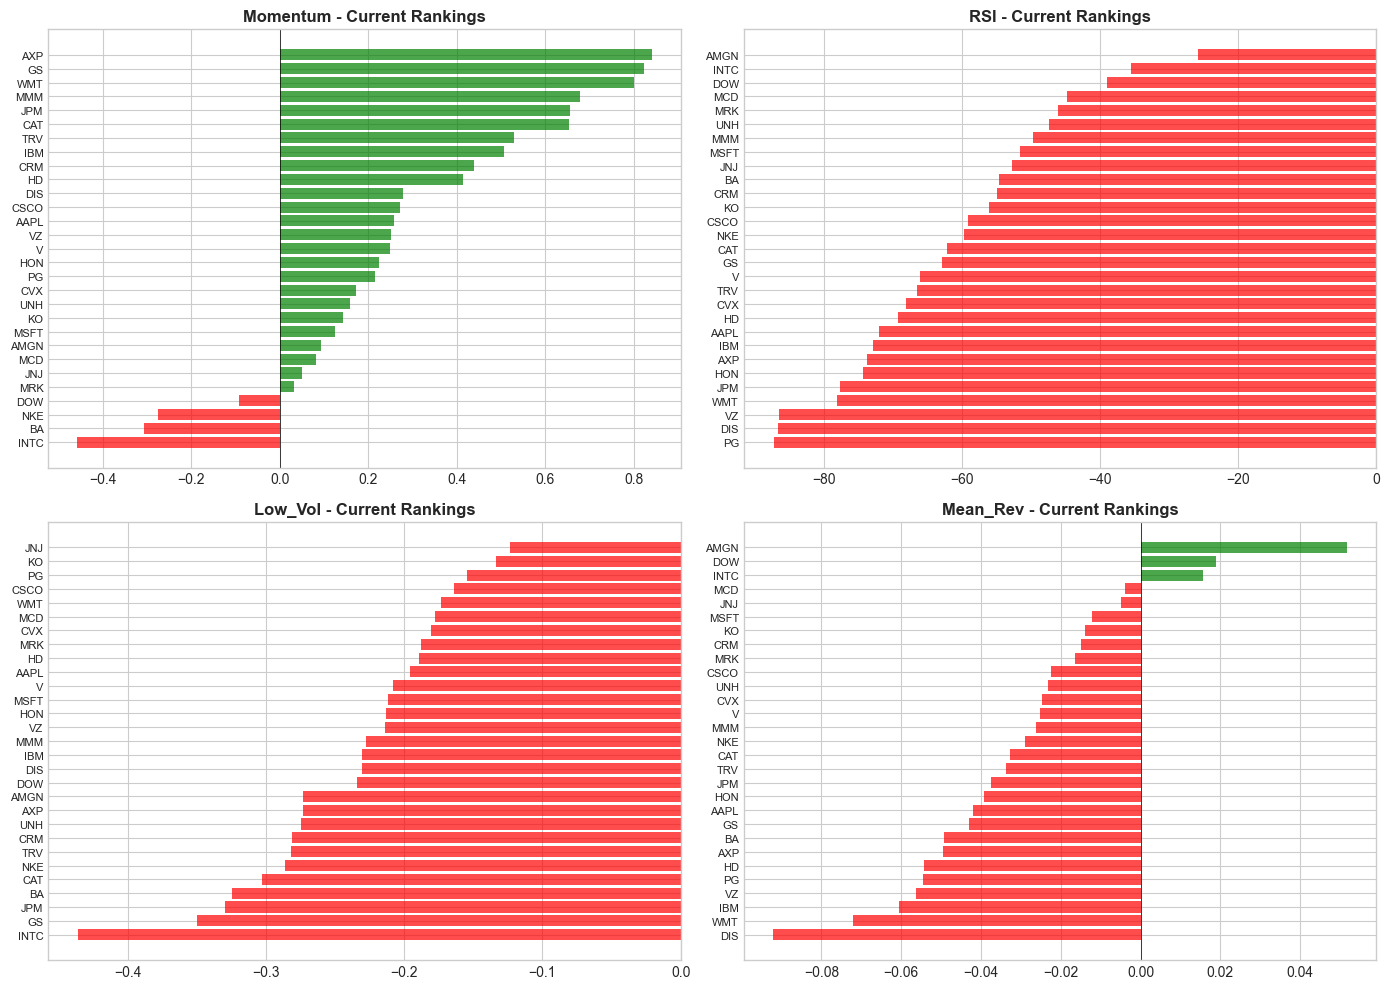


Latest factor values displayed above.


In [22]:
# Visualize current factor values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (name, factor) in enumerate(factors.items()):
    ax = axes[idx // 2, idx % 2]
    latest = factor.iloc[-1].dropna().sort_values()
    colors = ['green' if v > 0 else 'red' for v in latest]
    ax.barh(range(len(latest)), latest.values, color=colors, alpha=0.7)
    ax.set_yticks(range(len(latest)))
    ax.set_yticklabels(latest.index, fontsize=8)
    ax.set_title(f'{name} - Current Rankings', fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nLatest factor values displayed above.")

---

## Step 4: Information Coefficient (IC) Analysis

Evaluate predictive power of each factor:

In [23]:
# Calculate forward returns for IC analysis
fwd_returns = calculate_forward_returns(prices, periods=[21])['21D']

# Analyze each factor
print("Information Coefficient Analysis (21-day forward returns):")
print("="*60)

ic_results = {}
for name, factor in factors.items():
    ic_stats = ic_analysis(factor, fwd_returns)
    ic_results[name] = ic_stats
    
    mean_ic = ic_stats.get('mean_ic', 0)
    ic_std = ic_stats.get('ic_std', 0)
    hit_rate = ic_stats.get('hit_rate', 0)
    
    # Interpretation
    strength = "Strong" if abs(mean_ic) > 0.05 else "Weak" if abs(mean_ic) > 0.02 else "Negligible"
    
    print(f"\n{name}:")
    print(f"  Mean IC: {mean_ic:.4f} ({strength})")
    print(f"  IC Std: {ic_std:.4f}")
    print(f"  IC IR: {mean_ic/ic_std:.3f}" if ic_std > 0 else "  IC IR: N/A")
    print(f"  Hit Rate: {hit_rate*100:.1f}%")

Information Coefficient Analysis (21-day forward returns):

Momentum:
  Mean IC: -0.0103 (Negligible)
  IC Std: 0.0000
  IC IR: N/A
  Hit Rate: 0.0%

RSI:
  Mean IC: 0.0138 (Negligible)
  IC Std: 0.0000
  IC IR: N/A
  Hit Rate: 0.0%

Low_Vol:
  Mean IC: 0.0045 (Negligible)
  IC Std: 0.0000
  IC IR: N/A
  Hit Rate: 0.0%

Mean_Rev:
  Mean IC: 0.0224 (Weak)
  IC Std: 0.0000
  IC IR: N/A
  Hit Rate: 0.0%


---

## Step 5: Run Long-Short Backtests

Execute the backtest for each factor:

In [24]:
# Run backtests for each factor
print("Running backtests...")
print("="*60)

backtest_results = {}
for name, factor in factors.items():
    result = run_long_short(
        factor=factor,
        returns=returns,
        top_pct=TOP_PCT,
        bottom_pct=BOTTOM_PCT,
        rebalance_freq=REBALANCE_FREQ
    )
    backtest_results[name] = result
    
    sharpe = result.metrics.get('sharpe', 0)
    annual_ret = result.metrics.get('annual_return', 0) * 100
    max_dd = result.metrics.get('max_drawdown', 0) * 100
    
    print(f"\n{name}:")
    print(f"  Sharpe Ratio: {sharpe:.2f}")
    print(f"  Annual Return: {annual_ret:.1f}%")
    print(f"  Max Drawdown: {max_dd:.1f}%")

Running backtests...

Momentum:
  Sharpe Ratio: -0.14
  Annual Return: -2.1%
  Max Drawdown: -31.3%

RSI:
  Sharpe Ratio: 0.00
  Annual Return: -0.3%
  Max Drawdown: -16.1%

Low_Vol:
  Sharpe Ratio: -0.05
  Annual Return: -1.3%
  Max Drawdown: -31.9%

Mean_Rev:
  Sharpe Ratio: 0.21
  Annual Return: 1.5%
  Max Drawdown: -14.5%


In [25]:
# Build composite factor
print("\nBuilding composite factor...")

composite = composite_factor(factors, method='rank_average')
composite_result = run_long_short(
    factor=composite,
    returns=returns,
    top_pct=TOP_PCT,
    bottom_pct=BOTTOM_PCT,
    rebalance_freq=REBALANCE_FREQ
)
backtest_results['Composite'] = composite_result

print(f"\nComposite Factor Results:")
print(f"  Sharpe Ratio: {composite_result.metrics.get('sharpe', 0):.2f}")
print(f"  Annual Return: {composite_result.metrics.get('annual_return', 0)*100:.1f}%")
print(f"  Max Drawdown: {composite_result.metrics.get('max_drawdown', 0)*100:.1f}%")


Building composite factor...

Composite Factor Results:
  Sharpe Ratio: 0.07
  Annual Return: 0.2%
  Max Drawdown: -15.7%


---

## Step 6: Results Summary

In [26]:
# Summary table
print("\n" + "="*70)
print("                    BACKTEST RESULTS SUMMARY")
print("="*70)
print(f"\nUniverse: {UNIVERSE} | Period: {START_DATE} to {END_DATE}")
print(f"Rebalance: {REBALANCE_FREQ} | Long/Short: {TOP_PCT:.0%}")

print("\n" + "-"*70)
print(f"{'Factor':<15} {'Sharpe':>10} {'Return':>12} {'Max DD':>10} {'Mean IC':>10}")
print("-"*70)

for name, result in backtest_results.items():
    sharpe = result.metrics.get('sharpe', 0)
    ret = result.metrics.get('annual_return', 0) * 100
    dd = result.metrics.get('max_drawdown', 0) * 100
    ic = ic_results.get(name, {}).get('mean_ic', 0)
    
    print(f"{name:<15} {sharpe:>10.2f} {ret:>11.1f}% {dd:>9.1f}% {ic:>10.4f}")

print("="*70)


                    BACKTEST RESULTS SUMMARY

Universe: dow30 | Period: 2018-01-01 to 2024-12-01
Rebalance: M | Long/Short: 20%

----------------------------------------------------------------------
Factor              Sharpe       Return     Max DD    Mean IC
----------------------------------------------------------------------
Momentum             -0.14        -2.1%     -31.3%    -0.0103
RSI                   0.00        -0.3%     -16.1%     0.0138
Low_Vol              -0.05        -1.3%     -31.9%     0.0045
Mean_Rev              0.21         1.5%     -14.5%     0.0224
Composite             0.07         0.2%     -15.7%     0.0000


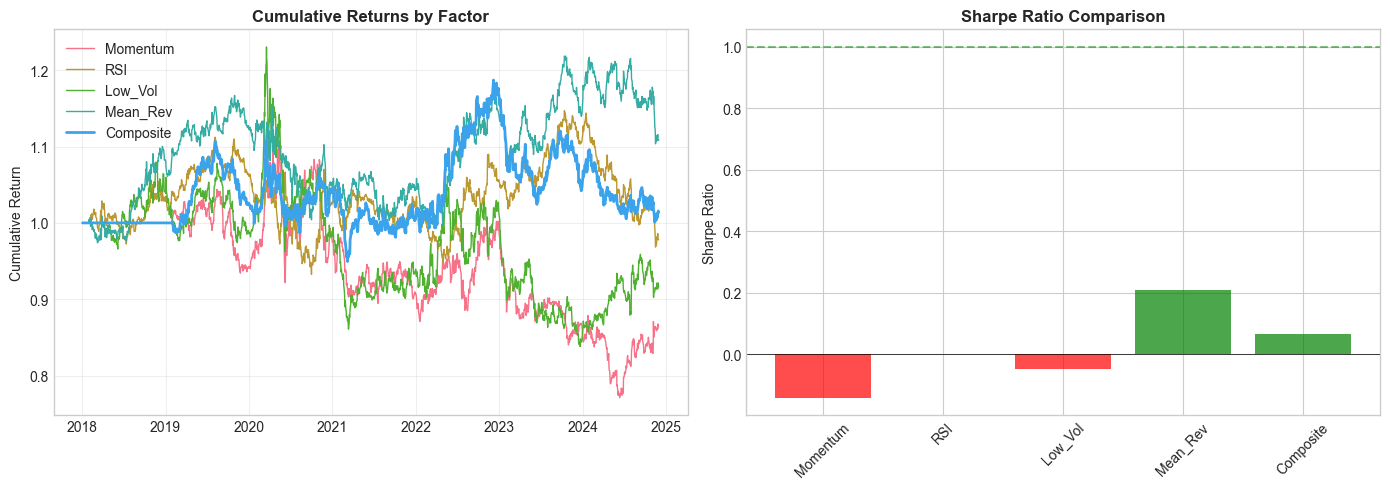


Results saved to reports/figures/backtest_results.png


In [27]:
# Visualize cumulative returns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cumulative returns
ax1 = axes[0]
for name, result in backtest_results.items():
    cumulative = (1 + result.portfolio_returns).cumprod()
    ax1.plot(cumulative.index, cumulative.values, label=name, linewidth=2 if name == 'Composite' else 1)

ax1.set_title('Cumulative Returns by Factor', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Sharpe comparison
ax2 = axes[1]
names = list(backtest_results.keys())
sharpes = [backtest_results[n].metrics.get('sharpe', 0) for n in names]
colors = ['green' if s > 0 else 'red' for s in sharpes]
ax2.bar(names, sharpes, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
ax2.set_title('Sharpe Ratio Comparison', fontweight='bold')
ax2.set_ylabel('Sharpe Ratio')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(str(project_root / 'reports' / 'figures' / 'backtest_results.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nResults saved to reports/figures/backtest_results.png")

---

## Step 7: Interactive Exploration

Explore specific stocks or modify parameters:

In [28]:
# Get current portfolio positions from the composite factor
latest_composite = composite.iloc[-1].dropna().sort_values(ascending=False)

n_long = max(1, int(len(latest_composite) * TOP_PCT))
n_short = max(1, int(len(latest_composite) * BOTTOM_PCT))

long_positions = latest_composite.head(n_long)
short_positions = latest_composite.tail(n_short)

print("CURRENT PORTFOLIO POSITIONS (Composite Factor)")
print("="*50)
print(f"\nLONG Positions ({n_long} stocks):")
for ticker, score in long_positions.items():
    print(f"  {ticker}: {score:.4f}")

print(f"\nSHORT Positions ({n_short} stocks):")
for ticker, score in short_positions.items():
    print(f"  {ticker}: {score:.4f}")

CURRENT PORTFOLIO POSITIONS (Composite Factor)

LONG Positions (5 stocks):
  MCD: 0.7155
  JNJ: 0.6983
  CSCO: 0.6983
  MMM: 0.6897
  KO: 0.6810

SHORT Positions (5 stocks):
  JPM: 0.3879
  NKE: 0.3448
  VZ: 0.3362
  DIS: 0.3017
  BA: 0.2931


In [29]:
# Save results to CSV
settings.ensure_dirs()
output_path = settings.processed_data_dir / "backtest_results_interactive.csv"

summary_df = pd.DataFrame([
    {
        'factor': name,
        **result.metrics,
        'mean_ic': ic_results.get(name, {}).get('mean_ic', 0)
    }
    for name, result in backtest_results.items()
])

summary_df.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

display(summary_df)

Results saved to data/processed/backtest_results_interactive.csv


,factor,total_return,annual_return,annual_volatility,sharpe,sortino,max_drawdown,calmar,win_rate,skewness,kurtosis,best_day,worst_day,n_periods,mean_ic
0,Momentum,-0.135871,-0.020939,0.108500,-0.140714,-0.238819,-0.313495,-0.066793,0.437033,-0.342849,5.348422,0.042829,-0.050302,1739,-0.010331
1,RSI,-0.022222,-0.003251,0.082109,0.001269,-0.064180,-0.161343,-0.020151,0.486486,0.750450,8.118572,0.054052,-0.027096,1739,0.013792
2,Low_Vol,-0.083827,-0.012607,0.118525,-0.047786,-0.149312,-0.318698,-0.039557,0.469235,-0.040165,3.438863,0.041229,-0.035552,1739,0.004497
3,Mean_Rev,0.108642,0.015058,0.090342,0.210576,0.251025,-0.145081,0.103789,0.496262,0.041583,2.497093,0.026445,-0.027827,1739,0.022415
4,Composite,0.014015,0.002019,0.079231,0.065075,0.034576,-0.156908,0.012867,0.422657,-0.185254,3.689088,0.019729,-0.040351,1739,0.000000


---

## Notebook Complete

You can now:
1. Modify the parameters in Step 1 and re-run the notebook
2. Add your own custom factors
3. Explore different universes or time periods